## MVP for GrowBikeNet implementation

### User Input:

In [223]:
from odc.geo.geom import multiline

city_name = 'Oslo'
seed_point_spacing = 1000 #distance between seed points
orig_crs = '4326'
proj_crs = '3857'
delta = 500 #maximal distance between seed point and actual point in OSM data

### Data from OSM

In [243]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import momepy
from shapely.prepared import prep
from shapely.geometry import Point, LineString, MultiLineString
from scipy.spatial import cKDTree
import math
from itertools import combinations
from shapely.ops import unary_union

In [3]:
g = ox.graph_from_place(city_name, network_type='all')

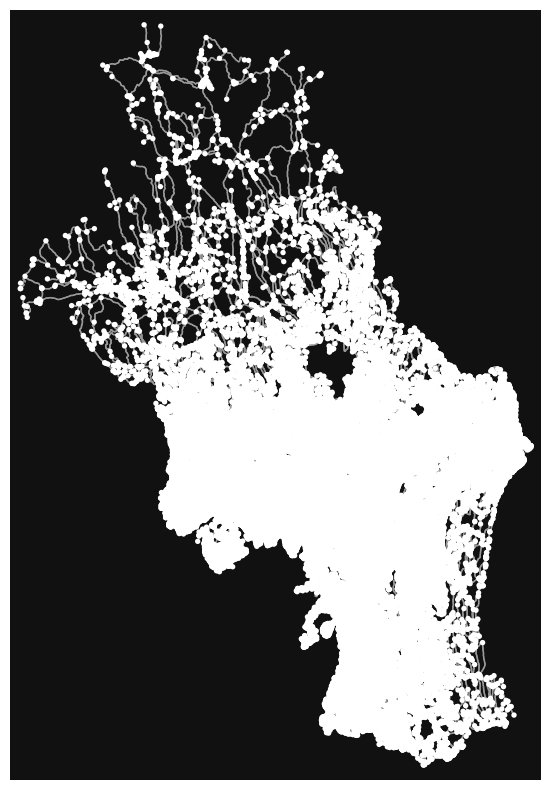

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [4]:
ox.plot_graph(g, figsize=(10, 10))

### Save Data

In [168]:
nodes, edges = momepy.nx_to_gdf(g, points=True, lines=True)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_60413/1992973538.py:1: UserWarning: Approach is not set. Defaulting to 'primal'.
  nodes, edges = momepy.nx_to_gdf(g, points=True, lines=True)


In [212]:
edges_gdf = gpd.GeoDataFrame(edges, crs=orig_crs)

In [213]:
edges_gdf

,osmid,highway,name,oneway,reversed,length,geometry,maxspeed,service,lanes,ref,bridge,tunnel,width,junction,access,area,est_width,node_start,node_end
0,5121777,residential,Bråtenalléen,False,False,4.320969,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,115620
1,107060586,residential,Morells vei,False,False,22.314074,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,126041
2,107060586,residential,Morells vei,False,True,28.928614,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,104931
3,5121777,residential,Bråtenalléen,False,True,29.293682,"LINESTRING (10.78342 59.94991, 10.78354 59.949...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,126046
4,4983011,residential,Grefsen allé,False,False,21.299113,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,5865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
343941,902776263,footway,NaN,False,False,63.132221,"LINESTRING (10.80984 59.91141, 10.80936 59.911...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127305,124097
343942,1468692932,service,NaN,False,False,104.735087,"LINESTRING (10.80984 59.91141, 10.8101 59.9120...",NaN,driveway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127305,127303
343943,1468692931,service,NaN,False,True,62.694830,"LINESTRING (10.80968 59.91164, 10.80975 59.911...",NaN,driveway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127306,127304
343944,338706912,service,Lysehagan,False,True,76.844213,"LINESTRING (10.62744 59.92705, 10.62757 59.927...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127307,22481


In [214]:
edges_gdf.to_crs(proj_crs, inplace=True)

In [188]:
nodes.to_crs(proj_crs, inplace=True)

In [190]:
nodes.to_file('nodes.gpkg', driver='GPKG')

In [191]:
edges_gdf.to_file('edges.gpkg', driver='GPKG')

### Convex Hull to create Polygon

In [192]:
hull = edges_gdf.union_all().convex_hull

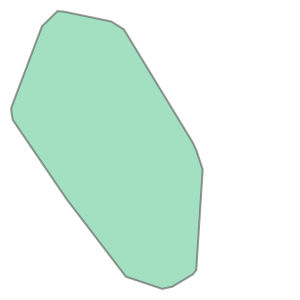

In [193]:
hull

### Generate evenly spaced seed points

In [194]:
latmin, lonmin, latmax, lonmax = hull.bounds

In [195]:
# https://stackoverflow.com/questions/66010964/fastest-way-to-produce-a-grid-of-points-that-fall-within-a-polygon-or-shape
prep_polygon = prep(hull)
points = []
for lat in np.arange(latmin, latmax, seed_point_spacing):
    for lon in np.arange(lonmin, lonmax, seed_point_spacing):
        points.append(Point((round(lat,4), round(lon,4))))

In [196]:
valid_points = []
valid_points.extend(filter(prep_polygon.contains, points))

In [199]:
points_df = pd.DataFrame(valid_points, columns=['Points'])

In [200]:
points_df

,Points
0,POINT (1170243.6036 8401535.3117)
1,POINT (1170243.6036 8402535.3117)
2,POINT (1170243.6036 8403535.3117)
3,POINT (1170243.6036 8404535.3117)
4,POINT (1170243.6036 8405535.3117)
...,...
2231,POINT (1218243.6036 8386535.3117)
2232,POINT (1218243.6036 8387535.3117)
2233,POINT (1218243.6036 8388535.3117)
2234,POINT (1218243.6036 8389535.3117)


In [215]:
points_gdf = gpd.GeoDataFrame(points_df, crs=3857, geometry='Points')

In [216]:
points_gdf.to_crs(3857)

,Points
0,POINT (1170243.604 8401535.312)
1,POINT (1170243.604 8402535.312)
2,POINT (1170243.604 8403535.312)
3,POINT (1170243.604 8404535.312)
4,POINT (1170243.604 8405535.312)
...,...
2231,POINT (1218243.604 8386535.312)
2232,POINT (1218243.604 8387535.312)
2233,POINT (1218243.604 8388535.312)
2234,POINT (1218243.604 8389535.312)


<Axes: >

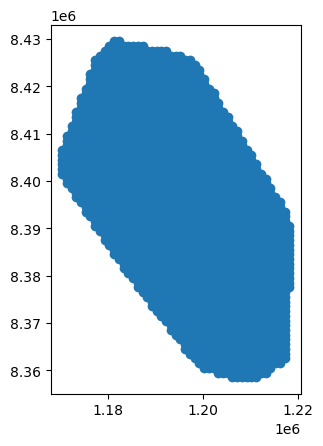

In [217]:
points_gdf.plot()

### Snap Seed points to OSM nodes

In [219]:
# https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
nA = np.array(list(points_gdf.geometry.apply(lambda x: (x.x, x.y))))
nB = np.array(list(nodes.geometry.apply(lambda x: (x.x, x.y))))
btree = cKDTree(nB)
dist, idx = btree.query(nA, k=1)
gdB_nearest = nodes.iloc[idx].drop(columns="geometry").reset_index(drop=True)
gdf = pd.concat(
    [
        points_gdf.reset_index(drop=True),
        gdB_nearest,
        pd.Series(dist, name='dist')
    ],
    axis=1)

In [226]:
gdf_cleaned = gdf.drop(gdf[gdf.dist > delta].index)
gdf_cleaned

,Points,y,x,street_count,nodeID,highway,junction,railway,ref,dist
0,POINT (1170243.604 8401535.312),60.007980,10.508699,3,101794,NaN,NaN,NaN,NaN,421.037046
5,POINT (1170243.604 8406535.312),60.031362,10.513930,3,15275,NaN,NaN,NaN,NM843559,248.211610
9,POINT (1171243.604 8402535.312),60.012257,10.520337,3,12549,NaN,NaN,NaN,NaN,142.354487
10,POINT (1171243.604 8403535.312),60.018677,10.522141,3,12043,NaN,NaN,NaN,NaN,369.802721
15,POINT (1171243.604 8408535.312),60.039588,10.525703,3,21098,NaN,NaN,NaN,NaN,472.754903
...,...,...,...,...,...,...,...,...,...,...
2231,POINT (1218243.604 8386535.312),59.941821,10.942336,1,66357,NaN,NaN,NaN,NaN,300.187630
2232,POINT (1218243.604 8387535.312),59.944949,10.942587,3,49232,NaN,NaN,NaN,NaN,128.088641
2233,POINT (1218243.604 8388535.312),59.949499,10.943558,3,17139,NaN,NaN,NaN,NaN,34.537508
2234,POINT (1218243.604 8389535.312),59.952912,10.944155,1,5076,NaN,NaN,NaN,NaN,278.788409


In [235]:
snapped_points = nodes.loc[nodes['nodeID'].isin(gdf_cleaned['nodeID'])]

In [236]:
snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'junction', 'railway', 'ref'], inplace=True)

/var/folders/0t/3k3_vhb54dgb_d5kncl6k_x00000gn/T/ipykernel_60413/2944866676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapped_points.drop(columns=['y', 'x','street_count', 'highway', 'junction', 'railway', 'ref'], inplace=True)


<Axes: >

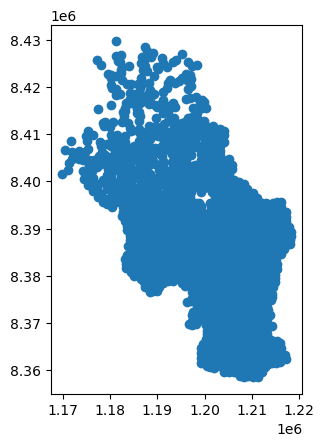

In [240]:
snapped_points.plot()

### Greedy triangulation

In [241]:
pairs = []
edges = []
distances = []

for pair in combinations(snapped_points["nodeID"], 2):

    edge = LineString(snapped_points.loc[list(pair)].geometry)

    pairs.append(pair)
    edges.append(edge)
    distances.append(edge.length)

df = pd.DataFrame(
    {
        "pair": pairs,
        "e": edges,
        "dist": distances
    }
)

df = df.sort_values(by="dist", ascending=True).reset_index(drop=True)
df = df[df["dist"]>0].reset_index(drop=True) # only keep distances > 0
df.tail(10)

,pair,e,dist
1136268,"(12669, 32978)",LINESTRING (1181282.9846706819 8429674.6927795...,75906.671673
1136269,"(12669, 53368)",LINESTRING (1181282.9846706819 8429674.6927795...,75988.302250
1136270,"(12428, 12669)",LINESTRING (1215199.306187868 8361541.03563801...,76108.554715
1136271,"(12669, 56425)",LINESTRING (1181282.9846706819 8429674.6927795...,76173.825517
1136272,"(12669, 43173)",LINESTRING (1181282.9846706819 8429674.6927795...,76323.504833
1136273,"(12669, 13639)",LINESTRING (1181282.9846706819 8429674.6927795...,76325.255251
1136274,"(6876, 12669)",LINESTRING (1216078.195831579 8361644.22774778...,76412.373947
1136275,"(12669, 39898)",LINESTRING (1181282.9846706819 8429674.6927795...,76639.403920
1136276,"(12669, 56430)",LINESTRING (1181282.9846706819 8429674.6927795...,76848.943573
1136277,"(12669, 57830)",LINESTRING (1181282.9846706819 8429674.6927795...,77242.002811


In [245]:
# helper function
def intersects_properly(geom1, geom2):
    '''
    for 2 shapely geometries, check whether they "properly intersect" (i.e. intersect but not touch, i.e. don't share endpoints)
    '''
    return geom1.intersects(geom2) and not geom1.touches(geom2)

In [251]:
# this should work, is suuuper slow tho (keyboard interrupt after 23 minutes)
# number of edges needs to be reduced

current_edges = MultiLineString()

# go through all node pair combinations, if they dont intersect with existing edges add to multilinestring
for _, row in df.iterrows():
    new_edge = row.e
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])

KeyboardInterrupt: 